<a href="https://colab.research.google.com/github/dtabuena/CrispMice/blob/main/Crispy_Analyze_ABF_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##### Git Test
################ Helpers ######################
def print_assert():
    'Print assertion failure messages (typicaly when try/except is employed)'
    import sys
    import traceback
    _, _, tb = sys.exc_info()
    # traceback.print_tb(tb) # Fixed format
    tb_info = traceback.extract_tb(tb)
    filename, line, func, text = tb_info[-1]
    print(text)
    return text


def flatten(list_of_lists):
    'Recursively Flatten list of lists'
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])


def protocol_baseline_and_stim(abf):
    'Return two boolean arrays, distiguishing holding I/V and electrical stimuli'
    # use command signal variance to determine stimulus periods
    commands = []
    for s in abf.sweepList:
        abf.setSweep(sweepNumber=s)
        commands.append(abf.sweepC)
    commands = np.stack(commands)
    
    std = np.std(commands, axis=0)
    is_base = std==0
    is_stim = np.logical_not(is_base)
    return is_base, is_stim

def abf_or_name(abf):
    if str(type(abf))=="<class 'str'>":
        abf = pyabf.ABF( abf )
    return abf

def plot_sweeps_and_command(abf,figsize = [8,2],windows=[]):
    'Plot an abf file with sweeps and command'
    'also attempts to calibrate telegraph offset when a Ch1 is a secondary ouput of the amp'
    abf = abf_or_name(abf)
    axs_2_right = []
    # plot sweeps and command (single channel)


    discretized_cmap = matplotlib.cm.get_cmap('viridis', len(abf.sweepList))

    num_ch = 1;
    if len(abf.channelList)>1:
        num_ch = 2
    fig, axs = plt.subplots(num_ch, figsize = np.array(figsize)*np.array([1,num_ch]))
    if num_ch ==1:
        axs=[axs]
    theta, offset, correct_ch1 = predict_telegraph(abf)
    if num_ch==2:
        axs1_r = axs[1].twinx()
        axs[1].set_ylabel(str('Ch1 '+str(abf.sweepLabelC)))
        axs1_r.set_ylabel(str('Corrrected '+str(abf.sweepLabelC)[-4:]) )
        axs[1].set_title(str(theta) +','+ str(offset))
        axs[1].set_title('Command Correction')
    axs0_r = axs[0].twinx()
    for sweep in abf.sweepList:
        abf.setSweep(sweepNumber=sweep)
        axs[0].plot(abf.sweepX, abf.sweepY,color=discretized_cmap(sweep))        
        axs0_r.plot(abf.sweepX, abf.sweepC,color='grey' )#discretized_cmap(sweep),linestyle='dotted')
        com = abf.sweepC
        if len(abf.channelList)>1:
            abf.setSweep(sweepNumber=sweep, channel=1)
            axs[1].plot(abf.sweepX, abf.sweepY,'m')
            corrected_com = correct_ch1(theta,abf.sweepY)
            axs1_r.plot(abf.sweepX, corrected_com,'c',linestyle='dotted')
            # axs_2.set_title( str(theta)+','+ str(correct_ch1(theta,abf.sweepY[0])) )
    axs[0].set_title(abf.abfID)
    abf.setSweep(0)
    axs[0].set_ylabel(str(abf.sweepLabelY))
    axs[0].set_xlabel(str(abf.sweepLabelX))
    axs0_r.set_ylabel(str(abf.sweepLabelC))
    axs0_r.set_xlabel(str(abf.sweepLabelX))

    cmap = matplotlib.cm.get_cmap('Dark2')
    color_num=0
    for w in windows:
        color_num+=1
        rgba = cmap(color_num/len(windows))
        ylim = axs[0].get_ylim()
        sr = np.mean(np.diff( w ))
        gaps = np.where(np.diff(w)>sr*4)[0]
        sw = flatten([w[0],[ list(w[[i,i+1]]) for i in np.arange(len(w)-1) if np.diff(w)[i] > sr*3 ] , w[-1] ])
        for i in range(0, len(sw), 2):
            axs[0].axvspan(sw[i], sw[i+1], ylim[0], ylim[1], alpha=0.2,color=rgba)


    axs[0].set_zorder(1)  # default zorder is 0 for ax1 and ax2
    axs[0].patch.set_visible(False)  # prevents ax1 from hiding ax2

    fig.tight_layout()
    plt.show()
    return fig, axs , theta


In [2]:

################# Math ######################
import math


def movmean(x, w):
    'A moving mean filter'
    w = int(w)
    # plt.plot(np.arange(len(x)) - int(len(x)/2), x)
    if len(x) < w: w = len(x)
    px = np.pad(x,int(np.ceil((w-1)/2)),'edge') 
    if len(px)-len(x) == w: px = px[0:-1]
    conv = np.convolve(px, np.ones(w), 'valid') / w
    return conv

def mono_exp(time, peak, tau, ss):
    'A single exponential decay function'
    return (peak * np.exp(-time / (tau)) + ss)

def rms_noise(x):
    return np.sqrt(    np.sum((x-x.mean())**2)/len(x)    )   

def predict_telegraph_DEFUNCT(abf,to_plot=False,stabilize_one_to_one = True,v_res = 10):
    'Uses the difference between the voltage protocol command and'
    'Secondary ouput channel to calcualte the offset and gain between'
    'amplifier and digitizer'
    abf = abf_or_name(abf)
    theta = [1,0]
    try:
        if len(abf.channelList)>1:
            all_ch1_y =[]
            all_ch0_com =[]
            for sweep in abf.sweepList:
                abf.setSweep(sweepNumber=sweep, channel=1)
                all_ch1_y.append(abf.sweepY)
                abf.setSweep(sweepNumber=sweep, channel=0)
                all_ch0_com.append(abf.sweepC)
            all_ch1_y = np.concatenate(all_ch1_y)
            all_ch0_com = np.concatenate(all_ch0_com)
            theta = np.polyfit(all_ch0_com, all_ch1_y, 1)
            # print(theta,'theta_1')
            modes = []
            steps = list(set(all_ch0_com))
            steps.sort()
            steps = np.array(steps)
            for s in steps:
                mode = scipy.stats.mode( all_ch1_y[all_ch0_com==s] )[0]
                modes.append(mode)
            modes = np.concatenate(modes)
            m_ind = [i for i in np.arange(len(modes)) if modes[i]<-40]
            steps = steps[m_ind]
            modes = modes[m_ind]
            theta = np.polyfit(steps, modes, 1)
            # print(theta,'theta_2')
            if to_plot:
                plt.scatter(steps,modes)
                y_hat = steps*theta[0]+theta[1]
                plt.plot(steps,  y_hat )
                plt.show()
            if to_plot:
                for s in steps:
                    counts, bin_edges = np.histogram( all_ch1_y[all_ch0_com==s],bins=50,range=(-120,70),density=True )
                    plt.plot(bin_edges[1:],counts)
                    mode = scipy.stats.mode( all_ch1_y[all_ch0_com==s] )
                    # plt.scatter(s,mode)
                plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
                plt.gca().grid()
                plt.show()
    except:
        'keep default theta'
    if stabilize_one_to_one:
        # if np.round(theta[0],1)==1.0:
        theta = [theta[0] , round(theta[1]/v_res)*v_res ]
        if theta[0]>1: theta[0]=math.floor(theta[0])

    offset = theta[1]/theta[0]
    def correct_ch1(t,signal):
        return t[1]/t[0] + (signal - t[1]) / t[0]
    return theta, offset, correct_ch1

def predict_telegraph(abf,to_plot=False,stabilize_one_to_one = True,v_res = 10):
    'Uses the difference between the voltage protocol command and'
    'Secondary ouput channel to calcualte the offset and gain between'
    'amplifier and digitizer'
    abf = abf_or_name(abf)
    theta = [1,0]
    try:
        if len(abf.channelList)>1:
            all_ch1_y =[]
            all_ch0_com =[]
            for sweep in abf.sweepList:
                abf.setSweep(sweepNumber=sweep, channel=1)
                all_ch1_y.append(abf.sweepY)
                abf.setSweep(sweepNumber=sweep, channel=0)
                all_ch0_com.append(abf.sweepC)
            all_ch1_y = np.concatenate(all_ch1_y)
            all_ch0_com = np.concatenate(all_ch0_com)

            test_theta = np.polyfit(all_ch0_com, all_ch1_y, 1)
            y_hat = test_theta[1]/test_theta[0] + (all_ch0_com - test_theta[1]) / test_theta[0]
            err = abs(y_hat-all_ch1_y)
            small_err = err<(np.mean(err)+0.2*np.std(err))
            if to_plot:
                plt.scatter(all_ch0_com[small_err],all_ch1_y[small_err])
                plt.show()
            theta = np.polyfit(all_ch0_com[small_err], all_ch1_y[small_err], 1)
    except:
        'keep default theta'
    offset = theta[1]/theta[0]
    def correct_ch1(theta,signal):
        return theta[1]/theta[0] + (signal - theta[1]) / theta[0]
    return theta, offset, correct_ch1

In [3]:

########## Importing ABFs From DropBox ################

def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'

    suffix_start = new_filename.find(".zip")
    new_filename_stripped = new_filename[0:suffix_start]
    zipped_file_path = "/content/"+new_filename
    unzipped_file_path = "/content/"+new_filename_stripped
    if not( os.path.exists(zipped_file_path)):
        !wget -O $new_filename $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename_stripped

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(file_loc): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list



def catalogue_recs(file_loc):
    'Read metadata from abf files stored in chosen folder and assigns'
    'them to a dataframe for further processing. All further abf analyses'
    'read files from this df and report values in the df.'

    file_list = get_sub_files(file_loc)
    # file_list = [file_loc+'/'+f for f in file_list]

    file_list=[f for f in file_list if '.abf' in f]

    abf_recordings_df = pd.DataFrame(data = file_list, columns=['file_name'])    
    abf_recordings_df = abf_recordings_df.set_index('file_name')
    abf_recordings_df["info"] = None
    abf_recordings_df["protocol"] = None
    abf_recordings_df["datetime"] = None
    abf_recordings_df["sweepList"] = None
    abf_recordings_df["channelList"] = None


    for r in np.arange(len(abf_recordings_df)):
        row_filename = abf_recordings_df.index[r]
        if '.sta' in row_filename:
            continue
        abf = pyabf.ABF(row_filename)
        abf_recordings_df.loc[row_filename,'info'] = str(abf)
        abf_recordings_df.loc[row_filename,'protocol'] = abf.protocol
        abf_recordings_df.at[row_filename,'sweepList'] = abf.sweepList
        abf_recordings_df.at[row_filename,'channelList'] = abf.channelList
        abf_recordings_df.at[row_filename,'datetime'] = abf.abfDateTimeString
    abf_recordings_df.sort_values('file_name',inplace=True)
    protocol_set = list(set(abf_recordings_df['protocol']))
    return abf_recordings_df, protocol_set




def find_pulses(command):
    'Searches a command signal for start and stop times'
    'of stimuli'
    is_base = command==command[0]
    is_step = np.logical_not(is_base)
    step_start = np.logical_and(is_base[:-1], is_step[1:])
    step_stop = np.logical_and(is_step[:-1], is_base[1:])
    starts = np.where(step_start)[0]
    stops = np.where(step_stop)[0]
    return starts, stops




In [21]:


##########################################################
##########  FIRING RATE GAIN ################

def IF_curve_analysis(abf_recordings_df,protocol_aliases,R2_thresh = 0.8, to_plot = 0 ):
    'Loop through all abfs finding approproate voltage protocols and calculates the firing rate gain, spikes per pA of all'

    abf_recordings_df['Gain_Stims_pA'] = None
    abf_recordings_df['Gain_NumSpikes'] = None
    abf_recordings_df['Gain_Stims_pA'] = abf_recordings_df['Gain_Stims_pA'].astype(object)
    abf_recordings_df['Gain_NumSpikes'] = abf_recordings_df['Gain_NumSpikes'].astype(object)
    abf_recordings_df['v_before_stim'] = None
    abf_recordings_df['Firing_Duration_%'] = np.nan
    
    spike_args = {'spike_thresh':10,
                    'high_dv_thresh': 25,
                    'low_dv_thresh': -5,
                     'window_ms': 2}



    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    for file_name in tqdm( abf_recordings_df.index[correct_protocol] ):
        try:
            gain_slope, R2, stim_currents, spike_counts, v_before_stim, fire_dur = analyze_gain_abf(file_name,spike_args,R2_thresh,to_plot) 

            abf_recordings_df.at[file_name,'Gain_Stims_pA'] = stim_currents
            abf_recordings_df.at[file_name,'Gain_NumSpikes'] = spike_counts
            abf_recordings_df.at[file_name,'v_before_stim'] = np.mean(v_before_stim)
            abf_recordings_df.at[file_name,'Firing_Gain_(Hz/pA)'] = gain_slope
            abf_recordings_df.at[file_name,'R2 (Firing_Gain_R2)'] = R2
            abf_recordings_df.at[file_name,'Firing_Duration_%'] = np.nanmedian(fire_dur)
        except: 
            print('unknown error on ', file_name)
    return abf_recordings_df



def analyze_gain_abf(file_name,spike_args,R2_thresh = 0.8, to_plot = 0):
    # print("#" , list(abf_recordings_df.index).index(file_name))
    abf = pyabf.ABF( file_name )
    if len(abf.sweepList)<5: #print( 'not enough sweeps')
        return np.nan, np.nan, np.nan, np.nan, np.nan , np.nan 
    is_base, is_stim = protocol_baseline_and_stim(abf)
    stim_currents, spike_counts, spike_rates,_,v_before_stim, fire_dur = spikes_per_stim(abf,spike_args, mode='count', to_plot=to_plot)
    if sum(spike_counts)==0:    #if no spikes return none
        return np.nan, np.nan, np.nan, np.nan, np.nan , np.nan 
    if_fit = fit_firing_gain( stim_currents, spike_counts, spike_rates ,to_plot=to_plot>0)
    gain_slope = if_fit['slope']
    R2 = if_fit['R2']
    return gain_slope, R2, stim_currents, spike_counts, v_before_stim, fire_dur

def spikes_per_stim(abf,spike_args,thresh=20,mode='count', to_plot=0):
    'Loops through sweeps of and abf to find spikes'
    # init
    stim_currents = []
    spike_rates = []
    spike_counts = []
    v_before_spike1 = []
    v_before_stim = []
    fire_dur = []
    # get sweep info
    is_base, is_stim = protocol_baseline_and_stim(abf)

    # get spike per sweep
    for s in abf.sweepList:
        abf.setSweep(s)
        dVds, over_thresh, inds, mean_spike_rate = find_spike_in_trace(abf.sweepY,abf.sampleRate,spike_args,is_stim=is_stim,mode='count',to_plot=to_plot)
        rel_firing_duration = check_inactivation( abf.sweepX, abf.sweepY, is_stim, abf.sampleRate, dVds, inds, mean_spike_rate, to_plot=0 )
        # plot id'd spikes
        if to_plot>1:
            fig, axs = plt.subplots(1)
            axs.scatter(abf.sweepX[inds],abf.sweepY[inds],color='red',zorder=2)
            axs.plot(abf.sweepX ,abf.sweepY,zorder=1)
            plt.show()
        # calc multi sweep params
        stim_level = np.median(abf.sweepC[is_stim])
        stim_currents.append(stim_level)
        spike_rates.append(mean_spike_rate)
        spike_counts.append(len(inds))
        is_prestim = np.equal(np.cumsum( np.diff(is_base,prepend=1)),0)
        v_before_stim.append( np.mean(abf.sweepY[is_prestim] ))
        fire_dur.append(rel_firing_duration)

        if len(inds)>0:
            v_before_spike1.append(abf.sweepY[inds[0]])
        else:
            v_before_spike1.append(np.nan)

    return np.array(stim_currents), np.array(spike_counts), np.array(spike_rates), np.array(v_before_spike1), np.array(v_before_stim) , np.array(fire_dur)


def find_spike_in_trace(trace,rate,spike_args,refract=0.005,is_stim = None ,mode='count',sanity_check=True,to_plot=0):
    'Takes in a voltage trace from current clamp mode and uses derivative (dVds) to find action potentials.'
    'Returns the dVds trace, boolean array indicating if dVds>threshold, inicies where dV crossed threshold,'
    'and the mean firing rate given # spikes in trace of given length. Optional ways to count are:'
    'isi (1/interspike interval) or count (spike count per second). Default is count'

    high_dv_thresh = spike_args['high_dv_thresh']
    low_dv_thresh = spike_args['low_dv_thresh']
    spike_thresh = spike_args['spike_thresh']
    window_ms = spike_args['window_ms']

    if any(is_stim == None):
        is_stim = [True for i in trace]
    dVds = np.diff(trace, prepend=trace[0])*rate/1000
    over_thresh = dVds>spike_thresh
    over_thresh[np.logical_not(is_stim)] = False
    refract_window = int(np.round((refract*rate)))
    inds = [t for t in np.arange(refract_window,len(over_thresh)) if all([over_thresh[t], all(over_thresh[t-refract_window:t]==False)])]    
    if sanity_check:
        old_inds = inds
        inds = []
        for i in old_inds:
            samp_window = window_ms/1000 * rate
            ind_range = np.arange(i-samp_window,i+samp_window).astype(int)
            nearby_dVds = dVds[ind_range]
            if False: print(i,'max', np.max(nearby_dVds))
            if False: print(i,'min', np.min(nearby_dVds))
            if np.max(nearby_dVds)>high_dv_thresh and np.min(nearby_dVds) < low_dv_thresh:
                inds.append(i)
                if False: print(inds)
    if to_plot>2:
        fig1, axs1 = plt.subplots(1,figsize = [9,2])
        axs1.plot(np.arange(len(dVds))/rate,dVds,zorder=1)
        axs1.scatter((np.arange(len(dVds))/rate)[inds],dVds[inds],color='red',zorder=2)
        plt.show()
    if len(inds)<1:
        mean_spike_rate = 0
    else:
        if mode=='isi':
            mean_spike_rate = np.mean(rate/np.diff(inds))
        elif mode=='count':
            mean_spike_rate = len(inds)/(np.sum(is_stim)/rate)
        else:
            print('invalid mode. using default (count)')
    return dVds, over_thresh, inds, mean_spike_rate

def fit_firing_gain(stim_currents, spike_counts, spike_rates, to_plot=False):
    'Gathers the firing rate of each stimuli and fits the linear portion of the curve to return the Gain in Hz/pA (the slope)'
    is_pos_slope = np.diff(spike_counts,prepend=0)>0
    is_pos_slope = movmean(np.diff(spike_counts,prepend=0),4)>0
    peak_ind = np.where(spike_counts==np.max(spike_counts))[0]
    if len(peak_ind)>1:
        peak_ind = np.min(peak_ind)
    
    before_peak = np.arange(len(spike_counts))<peak_ind
    is_nonzero = spike_counts>0
    use_for_fit = np.logical_and.reduce((is_pos_slope,is_nonzero,before_peak))

    if_fit = {}
    if_fit['stim_currents'] = stim_currents
    if_fit['spike_rates'] = spike_rates
    if 0 == np.sum(spike_rates):
        # print('no spikes detected')
        if_fit['slope'] = np.nan
        if_fit['intercept'] = np.nan
        if_fit['R2'] = 0
        return if_fit

    if np.sum(spike_rates>0)<3:
        # print('not enough spikes generated')
        if_fit['slope'] = np.nan
        if_fit['intercept'] = np.nan
        if_fit['R2'] = 0
        return if_fit

    if_fit['slope'], if_fit['intercept'] , r_value, p_value, std_err = stats.linregress(stim_currents[use_for_fit], spike_rates[use_for_fit])
    if_fit['R2'] = r_value**2

    if to_plot:
        fig, ax = plt.subplots(1, figsize=[3,3])
        ax.scatter( if_fit['stim_currents'] ,if_fit['spike_rates'] )
        ax.plot( if_fit['stim_currents'], if_fit['slope']* if_fit['stim_currents']+if_fit['intercept'])
        ax.scatter( if_fit['stim_currents'][use_for_fit] ,if_fit['spike_rates'][use_for_fit], color='r' )
        ax.scatter(if_fit['stim_currents'][peak_ind],if_fit['spike_rates'][peak_ind], color='m')
        ax.set_xlabel('current')
        ax.set_ylabel('Spike Rate (Hz)')
        (min,max) = ax.get_ylim()
        ax.text(0, max/2, 'R**2='+str(round(if_fit['R2'],2)),fontsize='large')
        plt.show()
    return if_fit

def check_inactivation( time, trace, is_stim, sample_rate, dVds, inds, mean_spike_rate, to_plot=0 ):
    time_ms = time*1000
    sum_isi = np.nan
    rel_firing_duration = np.nan
    if len(inds)>1:
        isi = np.diff(time_ms[inds])
        sum_isi = np.sum(isi)
        stim_time = time_ms[np.where(is_stim)[0][0]]
        first_time = time_ms[inds[0]]-stim_time
        firing_duration = first_time+sum_isi
        rel_firing_duration = firing_duration /(np.max(time[is_stim]*1000)-stim_time)
    return rel_firing_duration



# file_name = '2022-08-08_hipp_data/2022x08x04_NEL2_E4KI_F_P243_s001_c003_DGxNEG_0004.abf'
# R2_thresh = 0
# to_plot = 1

# gain_slope, R2, stim_currents, spike_counts, v_before_stim, fire_dur = analyze_gain_abf(file_name,spike_args,R2_thresh,to_plot) 
# print(np.nanmedian(fire_dur))

In [5]:

########## Rheobase analysis ################
def Rheo_curve_analysis(abf_recordings_df, protocol_aliases,to_plot = False,single_spike=True,verbose=False):
    'Loop through abfs to calculate Rheobase. For each abf the first sweep with '
    'a spike that occurs after a sweep without is chosen, and its stimulus amplitude'
    'is written to the dataframe'
    # return dataframe with updated min stim intensity
    abf_recordings_df['Rheobase_(pA)'] = np.nan
    abf_recordings_df['step_resolution_(pA)']  = np.nan
    abf_recordings_df['Rheo Ihold_(pA)']  = np.nan
    abf_recordings_df['Vhold_Rheo_(mV)']  = np.nan


    spike_args = {'spike_thresh':10,
                    'high_dv_thresh': 25,
                    'low_dv_thresh': -5,
                     'window_ms': 2}


    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    for file_name in tqdm( abf_recordings_df.index[correct_protocol]):
        if verbose: print(file_name)
        rheo, step_resolution, offset, Vhold_spike, ap_thresh = analyze_rheo(file_name,spike_args,to_plot=to_plot,verbose=verbose,single_spike=single_spike)

        abf_recordings_df.at[file_name,'Rheobase_(pA)'] = rheo
        abf_recordings_df.at[file_name,'step_resolution_(pA)'] = step_resolution
        abf_recordings_df.at[file_name,'Rheo Ihold_(pA)'] = offset
        abf_recordings_df.at[file_name,'Vhold_Rheo_(mV)'] = Vhold_spike
        abf_recordings_df.at[file_name,'AP_Threshold(mV)'] = ap_thresh

    return abf_recordings_df



def analyze_rheo(file_name,spike_args,to_plot=False,verbose=False,single_spike=True):
    abf = abf_or_name(file_name)
    if to_plot: plot_sweeps_and_command(abf)
    if len(abf.sweepList)<2:
        return np.nan,np.nan,np.nan,np.nan,np.nan  
    else:
        is_base, is_stim = protocol_baseline_and_stim(abf)
        stim_currents, spike_counts, spike_rates, V_before,_,_ = spikes_per_stim(abf, spike_args,thresh=20,to_plot=to_plot)
        if verbose: print(spike_counts)
        single_spikes = spike_counts==1
        zero_spikes = spike_counts==0
        if single_spike:
            none_to_one = np.full(single_spikes.shape, False)
            none_to_one[1:] = np.logical_and(single_spikes[1:], zero_spikes[:-1])
            first_spike_stim = np.where(none_to_one)[0]
        else:
            some_spikes = spike_counts>0
            none_to_some = np.full(single_spikes.shape, False)
            none_to_some[1:] = np.logical_and(some_spikes[1:], zero_spikes[:-1])
            first_spike_stim = np.where(none_to_some)[0]
    if first_spike_stim.size == 0:
        return np.nan,np.nan,np.nan,np.nan,np.nan 
    else:
        if first_spike_stim.size >1:
            first_spike_stim = np.min(first_spike_stim)
        rheo = stim_currents[first_spike_stim]
        _, _, _, QC_val_df = Iclamp_QC(file_name)
        offset = np.mean(QC_val_df['I_leak'])
        Vhold_spike = QC_val_df['V_hold'][first_spike_stim]
        ap_thresh = V_before[first_spike_stim]
        step_resolution = np.mean(np.diff(stim_currents))

    return rheo, step_resolution, offset, Vhold_spike, ap_thresh 

def spikes_per_stim(abf,spike_args,thresh=20,mode='count', to_plot=0):
    'Loops through sweeps of and abf to find spikes'
    # init
    stim_currents = []
    spike_rates = []
    spike_counts = []
    v_before_spike1 = []
    v_before_stim = []
    fire_dur = []
    # get sweep info
    is_base, is_stim = protocol_baseline_and_stim(abf)

    # get spike per sweep
    for s in abf.sweepList:
        abf.setSweep(s)
        dVds, over_thresh, inds, mean_spike_rate = find_spike_in_trace(abf.sweepY,abf.sampleRate,spike_args,is_stim=is_stim,mode='count',to_plot=to_plot)
        rel_firing_duration = check_inactivation( abf.sweepX, abf.sweepY, is_stim, abf.sampleRate, dVds, inds, mean_spike_rate, to_plot=0 )
        # plot id'd spikes
        if to_plot>1:
            fig, axs = plt.subplots(1)
            axs.scatter(abf.sweepX[inds],abf.sweepY[inds],color='red',zorder=2)
            axs.plot(abf.sweepX ,abf.sweepY,zorder=1)
            plt.show()
        # calc multi sweep params
        stim_level = np.median(abf.sweepC[is_stim])
        stim_currents.append(stim_level)
        spike_rates.append(mean_spike_rate)
        spike_counts.append(len(inds))
        is_prestim = np.equal(np.cumsum( np.diff(is_base,prepend=1)),0)
        v_before_stim.append( np.mean(abf.sweepY[is_prestim] ))
        fire_dur.append(rel_firing_duration)

        if len(inds)>0:
            v_before_spike1.append(abf.sweepY[inds[0]])
        else:
            v_before_spike1.append(np.nan)

    return np.array(stim_currents), np.array(spike_counts), np.array(spike_rates), np.array(v_before_spike1), np.array(v_before_stim) , np.array(fire_dur)

# def spikes_per_stim(abf, spike_args,thresh=20,mode='count', to_plot=False):
#     'Loops through sweeps of and abf to find spikes'
#     # init
#     stim_currents = []
#     spike_rates = []
#     spike_counts = []
#     v_before_spike1 = []
#     v_before_stim = []
#     # get sweep info
#     is_base, is_stim = protocol_baseline_and_stim(abf)

#     # get spike per sweep
#     for s in abf.sweepList:
#         abf.setSweep(s)
#         dVds, over_thresh, inds, mean_spike_rate = find_spike_in_trace(abf.sweepY,abf.sampleRate,spike_args,to_plot=to_plot,is_stim=is_stim,mode='count')
#         # plot id'd spikes
#         if to_plot:
#             fig, axs = plt.subplots(1)
#             axs.plot(abf.sweepX ,abf.sweepY)
#             axs.scatter(abf.sweepX[inds],abf.sweepY[inds],color='red')
#             plt.show()
#         # calc multi sweep params
#         stim_level = np.median(abf.sweepC[is_stim])
#         stim_currents.append(stim_level)
#         spike_rates.append(mean_spike_rate)
#         spike_counts.append(len(inds))
#         is_prestim = np.equal(np.cumsum( np.diff(is_base,prepend=1)),0)
#         v_before_stim.append( np.mean(abf.sweepY[is_prestim] ))

#         if len(inds)>0:
#             v_before_spike1.append(abf.sweepY[inds[0]])
#         else:
#             v_before_spike1.append(np.nan)

#     return np.array(stim_currents), np.array(spike_counts), np.array(spike_rates), np.array(v_before_spike1), np.array(v_before_stim)



def find_spike_in_trace(trace,rate,spike_args,refract=0.005,is_stim = None ,mode='count',sanity_check=True,to_plot=0):
    'Takes in a voltage trace from current clamp mode and uses derivative (dVds) to find action potentials.'
    'Returns the dVds trace, boolean array indicating if dVds>threshold, inicies where dV crossed threshold,'
    'and the mean firing rate given # spikes in trace of given length. Optional ways to count are:'
    'isi (1/interspike interval) or count (spike count per second). Default is count'

    high_dv_thresh = spike_args['high_dv_thresh']
    low_dv_thresh = spike_args['low_dv_thresh']
    spike_thresh = spike_args['spike_thresh']
    window_ms = spike_args['window_ms']

    if any(is_stim == None):
        is_stim = [True for i in trace]
    dVds = np.diff(trace, prepend=trace[0])*rate/1000
    over_thresh = dVds>spike_thresh
    over_thresh[np.logical_not(is_stim)] = False
    refract_window = int(np.round((refract*rate)))
    inds = [t for t in np.arange(refract_window,len(over_thresh)) if all([over_thresh[t], all(over_thresh[t-refract_window:t]==False)])]    
    if sanity_check:
        old_inds = inds
        inds = []
        for i in old_inds:
            samp_window = window_ms/1000 * rate
            ind_range = np.arange(i-samp_window,i+samp_window).astype(int)
            nearby_dVds = dVds[ind_range]
            if False: print(i,'max', np.max(nearby_dVds))
            if False: print(i,'min', np.min(nearby_dVds))
            if np.max(nearby_dVds)>high_dv_thresh and np.min(nearby_dVds) < low_dv_thresh:
                inds.append(i)
                if False: print(inds)
    if to_plot>2:
        fig1, axs1 = plt.subplots(1,figsize = [9,2])
        axs1.plot(np.arange(len(dVds))/rate,dVds,zorder=1)
        axs1.scatter((np.arange(len(dVds))/rate)[inds],dVds[inds],color='red',zorder=2)
        plt.show()
    if len(inds)<1:
        mean_spike_rate = 0
    else:
        if mode=='isi':
            mean_spike_rate = np.mean(rate/np.diff(inds))
        elif mode=='count':
            mean_spike_rate = len(inds)/(np.sum(is_stim)/rate)
        else:
            print('invalid mode. using default (count)')
    return dVds, over_thresh, inds, mean_spike_rate

In [6]:

################################## Analyze R-Input In Current Clamp ##################################

def inputR_analysis(abf_recordings_df, protocol_aliases,to_plot=False, verbose = False):
    'Loop through abfs to calculate the input resistance in Current Clamp'
    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    for file_name in tqdm( abf_recordings_df.index[correct_protocol] ):
        abf = pyabf.ABF( file_name )
        if len(abf.sweepList)<2:
            # print(list(abf_recordings_df.index).index(file_name),    'not enough sweeps')
            abf_recordings_df.at[file_name,'Rinput_(MO)'] = np.nan
            abf_recordings_df.at[file_name,'Cmf_IC_(pF)'] = np.nan
            continue
            
        inputR_fit = input_res_curve(abf,to_plot=to_plot)
        abf_recordings_df.at[file_name,'Rinput_(MO)'] = inputR_fit['slope']*1000
        if len(abf_recordings_df.at[file_name,'passing_sweeps'])==0:
            abf_recordings_df.at[file_name,'Cmf_IC_(pF)'] = np.nan
            continue
        Cmf_IC = IC_sweep_capacitance_mean(abf,abf_recordings_df.at[file_name,'passing_sweeps'],to_plot=to_plot,verbose=verbose)
        abf_recordings_df.at[file_name,'Cmf_IC_(pF)'] = Cmf_IC
    return abf_recordings_df


def input_res_curve(abf,to_plot=False):
    'Calulates the series of delta Vs and delta Is and fits with a line to find the resistance.'
    from scipy.signal import butter,filtfilt
    stim_currents = []
    ss_voltage = []
    is_base, is_stim = protocol_baseline_and_stim(abf)
    for s in abf.sweepList:
        abf.setSweep(s)
        delta_v, _, _ = sweep_VIR(abf.sweepY, abf.sampleRate, is_stim = is_stim)
        delta_I, _, _    = sweep_VIR(abf.sweepC, abf.sampleRate, is_stim = is_stim) # repurpose but for command current
        stim_currents.append( delta_I)
        ss_voltage.append(delta_v)
    
    inputR_fit = {}
    inputR_fit['slope'], inputR_fit['intercept'] , r_value, p_value, std_err = stats.linregress(stim_currents, ss_voltage)
    inputR_fit['R2'] = r_value**2
    if to_plot:
        plt.scatter(stim_currents, ss_voltage)
        matplotlib.pyplot.text(10, 0, 'Ri = ' + str(round(inputR_fit['slope']*1000)) + 'MO')
    return inputR_fit        

def sweep_VIR(trace,rate,is_stim = None, window_t=0.100):
    'Takes a trace snd calulates the steady state delta V from'
    'a stimulus in Current Clamp'
    if any(is_stim == None):
        is_stim = [True for i in trace]
    base_v = trace[:np.where(is_stim==True)[0][0]]
    cutoff = 5
    nyq = rate/2
    normal_cutoff = cutoff / nyq
    b, a = butter(3, normal_cutoff, btype='low')
    filtered_step_v = filtfilt(b, a, trace[is_stim])
    window_wid = int(window_t*rate)
    med_base_v = np.median(base_v[-window_wid:-1])
    med_stim_v = np.median(filtered_step_v[-window_wid:-1])
    delta_v = med_stim_v - med_base_v
    return delta_v, med_base_v, med_stim_v

def binary_exp(time, amp_1, amp_2, tau_1, tau_2, ss):
    'A double exponential decay function'
    return (amp_1 * np.exp(-time /tau_1)) + (amp_2 * np.exp(-time / tau_2))  + ss


def IC_sweep_capacitance_mean(abf,passing_sweeps,to_plot=False, verbose = False):
    'Takes an abf and calulates the membrane capacitance using'
    'methods described in https://journals.physiology.org/doi/epdf/10.1152/jn.00160.2009'
    
    
    is_base, is_stim = protocol_baseline_and_stim(abf)
    rVm_list = []
    V0_list = []
    SS_list = []
    Stim_list = []
    time = abf.sweepX[is_stim]
    time = time - time[0]
    # for s in abf.sweepList:
    for s in passing_sweeps:
        abf.setSweep(s)
        Istim = abf.sweepC[is_stim]
        if not( np.mean(Istim) < 0 ):
            continue
        Vm = abf.sweepY[is_stim]
        SS = np.percentile(Vm,.0001)
        V0 = Vm[0]
        relative_Vm = (Vm - SS) / (V0-SS)
        rVm_list.append(relative_Vm)
        V0_list.append(V0)
        SS_list.append(SS)
        Stim_list.append(np.median(Istim))
    if len(V0_list)<1:
        'likely there are passing sweeps but they are positive current'
        return np.nan
    
    rVm_array = np.stack(rVm_list).T
    V0_array = np.array(V0_list)
    SS_array = np.array(SS_list)
    Stim_array = np.array(Stim_list)
    mean_rVm = np.mean(rVm_array,axis=-1)
    if to_plot:
        plt.plot(time,rVm_array,'gray')
        plt.plot(time,mean_rVm,'k')


    p0 = ( 0.1, 0.8, 0.0001,  0.01, 0)
    bounds=([0,.3,0,.01,-.2], [0.25,1.2,.01,2,.2])

    try:
        fit_params, cv = scipy.optimize.curve_fit(binary_exp, time, mean_rVm, p0, bounds=bounds) #
        amp_1, amp_2, tau_1, tau_2, ss = fit_params
        Vm_hat = binary_exp(time, amp_1, amp_2, tau_1, tau_2, ss)

        Vm_hat1 = binary_exp(time, amp_1, 0, tau_1, tau_2, ss) + amp_2
        Vm_hat2 = binary_exp(time, 0, amp_2,  tau_1, tau_2, ss) + amp_1

        t_slow = tau_2*np.ones_like(V0_array)
        dv_slow = (SS_array - V0_array) * amp_2 *1e-3
        i_stim = Stim_array*1e-12
        r_slow = dv_slow/i_stim
        c_slow = t_slow /r_slow
        Cmf_IC = c_slow*1e12
    except:
        print(V0_array)
        print(Stim_array)
        print(SS_array)
        return np.nan 

    if verbose:
        print('V0', V0_array)
        print('I', i_stim*1e12)
        print('dV', dv_slow*1e3)
        print('SSv', SS_array)
        print('Rm', r_slow*1e-6)
        print('Cm', Cmf_IC)
        print('amp_1, amp_2, tau_1, tau_2, ss')
        print('Fit', fit_params)

    if to_plot:
        plt.plot(time,Vm_hat,'r')
        plt.plot(time,Vm_hat1,'c')
        plt.plot(time,Vm_hat2,'m')
        plt.show()

    return np.mean(Cmf_IC)




 

In [18]:
##################################  Quality Control Filtering ##################################
def QC_full_dataset(abf_recordings_df,to_plot=False,verbose=False,VC_prot=[],IC_prot=[],MT_prot=[]):
    'Loop through all abfs to look for signs of a poor recording including leak current, unstable holding V/I,'
    'high noise, and in appropriate holidng potential'

    # abf_recordings_df['QC_checks'] = None
    # abf_recordings_df['QC_values'] = None
    abf_recordings_df['passing_sweeps'] = None

    print('Voltage Clamp Protocols')
    VC_idx = [p in VC_prot for p in abf_recordings_df['protocol']]
    for fn in tqdm( abf_recordings_df[VC_idx].index ):
        if verbose: print(np.where(fn==abf_recordings_df.index)[0])
        try:
            pass_rate, passing_sweeps, QC_check_df, QC_val_df = Vclamp_QC(fn,to_plot=to_plot,verbose=verbose)
            abf_recordings_df.at[fn,'passing_sweeps'] = np.array(passing_sweeps)
        except AssertionError:
            if verbose: print_assert()
            abf_recordings_df.at[fn,'passing_sweeps'] = []

    print('Current Clamp Protocols')
    IC_idx = [p in IC_prot for p in abf_recordings_df['protocol']]
    for fn in tqdm( abf_recordings_df[IC_idx].index ):
        if verbose: print(np.where(fn==abf_recordings_df.index)[0])
        try:
            pass_rate, passing_sweeps, QC_check_df, QC_val_df = Iclamp_QC(fn,to_plot=to_plot,verbose=verbose)
            abf_recordings_df.at[fn,'passing_sweeps'] = np.array(passing_sweeps)
        except AssertionError:
            if verbose: print_assert()
            abf_recordings_df.at[fn,'passing_sweeps'] = []
       
    return abf_recordings_df


def Vclamp_QC(file_name, max_leak=200,max_high_freq_noise = 10, max_low_freq_noise = 15,
              Vhold_range = 8, to_plot=False,verbose=False):
    'Look for signs of a poor recording for Voltage Clamp recordings'
    is_VC = np.nan
    is_Ic = np.nan
    abf = pyabf.ABF( file_name )
    if 'mV' in abf.sweepLabelY:
        is_IC = True
        is_VC = False
    if 'pA' in abf.sweepLabelY:
        is_IC = False
        is_VC = True


    try:
        assert is_VC==True, 'Wrong clamp mode for protocol. Voltage protocol used during current clamp!'
    except AssertionError as e:
        print(e)
        return 0, [], [], []



    # assert is_VC==True, 'Wrong clamp mode for protocol. Voltage protocol used during current clamp!'
    

    theta, command_offset, correct_ch1 =  predict_telegraph(abf)


    QC_check_list = []
    QC_val_list = []
    for s in abf.sweepList:
        abf.setSweep(s,0)
        QC_checks, QC_values, windows = qc_sweep(abf.sweepX,abf.sweepC,abf.sweepY,command_offset,is_IC,is_VC,abf.sampleRate,                                                 
                                                 max_leak=max_leak,
                                                 max_high_freq_noise = max_high_freq_noise,
                                                 max_low_freq_noise = max_low_freq_noise,
                                                 Vhold_range = Vhold_range, to_plot=False)
        QC_check_list.append(QC_checks)
        QC_val_list.append(QC_values)
    
    QC_check_df = pd.DataFrame({'sweep' : np.arange(len(QC_val_list))}).set_index('sweep')
    for i in np.arange(len(QC_check_list)):
        d = QC_check_list[i]
        for (k,v) in d.items():
            QC_check_df.at[i,k]=v

    QC_val_df = pd.DataFrame({'sweep' : np.arange(len(QC_val_list))}).set_index('sweep')
    for i in np.arange(len(QC_val_list)):
        d = QC_val_list[i]
        for (k,v) in d.items():
            QC_val_df.at[i,k]=v

    pass_rate = {}
    for c in QC_check_df.columns:
        pass_rate[c] = np.round(np.mean(np.array(QC_check_df[c].values).astype(int))*100,2)

    if to_plot:
        fig, ax, theta = plot_sweeps_and_command(abf,windows=windows)
        plt.show()

    passing_sweeps = [s for s in QC_check_df.index if all(QC_check_df.loc[s,:])]
    if verbose: print('\n','pass_rate:',pass_rate)
    if verbose: print('passing_sweeps:',passing_sweeps)
    return pass_rate, passing_sweeps, QC_check_df, QC_val_df

def Iclamp_QC(file_name, max_leak=250, to_plot=False,verbose=False):
    'Look for signs of a poor recording for Current Clamp recordings'
    abf = abf_or_name(file_name)
    # abf = pyabf.ABF( file_name )
    if 'mV' in abf.sweepLabelY:
        is_IC = True
        is_VC = False
    if 'pA' in abf.sweepLabelY:
        is_IC = False
        is_VC = True
    try:
        assert is_IC==True, 'Wrong clamp mode for protocol. IC protocol used during voltage clamp!'
    except AssertionError as e:
        print(e)

    # assert is_IC==True, 'Wrong clamp mode for protocol. IC protocol used during voltage clamp!'

    theta, command_offset, correct_ch1 =  predict_telegraph(abf)
    
    QC_check_list = []
    QC_val_list = []
    for s in abf.sweepList:
        abf.setSweep(s,0)
        QC_checks, QC_values, windows = qc_sweep(abf.sweepX,abf.sweepC,abf.sweepY,command_offset,is_IC,is_VC,
                                                 abf.sampleRate,to_plot=to_plot, max_high_freq_noise = .05, max_low_freq_noise = 0.4, Vhold_range=3)
        QC_check_list.append(QC_checks)
        QC_val_list.append(QC_values)
    
    QC_check_df = pd.DataFrame({'sweep' : np.arange(len(QC_val_list))}).set_index('sweep')
    for i in np.arange(len(QC_check_list)):
        d = QC_check_list[i]
        for (k,v) in d.items():
            QC_check_df.at[i,k]=v

    QC_val_df = pd.DataFrame({'sweep' : np.arange(len(QC_val_list))}).set_index('sweep')
    for i in np.arange(len(QC_val_list)):
        d = QC_val_list[i]
        for (k,v) in d.items():
            QC_val_df.at[i,k]=v

    pass_rate = {}
    mean_values = {}
    for c in QC_check_df.columns:
        pass_rate[c] = np.round(np.mean(np.array(QC_check_df[c].values).astype(int))*100,2)
        mean_values[c] = np.round(np.mean(np.array(QC_val_df[c].values)),3)
    passing_sweeps = [s for s in QC_check_df.index if all(QC_check_df.loc[s,:])]
    
    if verbose==True: 
        print('')
        print('pass_rate:',pass_rate)
        print('mean_values:',mean_values)
    if verbose==2:
        print('\n','pass_rate:',pass_rate)
        print('passing_sweeps:',passing_sweeps, str(len(passing_sweeps)/len(QC_check_df)*100)+'%')
        print(QC_val_df)

    if to_plot:
        fig, ax, theta = plot_sweeps_and_command(abf,windows=windows)
        plt.show()

    return [pass_rate,passing_sweeps,QC_check_df,QC_val_df] # return pass_rate, passing_sweeps, QC_check_df, QC_val_df

def qc_sweep(sweepX,sweepC,sweepY,command_offset,is_IC,is_VC,sampleRate,
             max_leak=100, 
             max_high_freq_noise = 10,
             max_low_freq_noise = 10,
             Vhold_range = 5, to_plot=False):
    'Recieves a sweep and and calculates leak, noise and holding potential'
    'returns a dict of calculated values and a dict of boolean indicating'
    'pass/fail, (True/False)'


    stim_buffer_time = 250 #ms
    filtered_command = movmean((sweepC==sweepC[0])*1, stim_buffer_time/1000*sampleRate)
    ss_no_stim_bool = filtered_command==1
    ss_no_stim_idx = np.arange(len(ss_no_stim_bool))[ss_no_stim_bool]
    no_stim_sig = sweepY[ss_no_stim_bool]
    no_stim_t = sweepX[ss_no_stim_idx]
    baseline = np.mean( no_stim_sig )

    QC_checks = {}
    QC_values = {}
    if is_IC:
        QC_values['V_hold'] = baseline
        QC_values['I_leak'] = command_offset
    if is_VC:
        QC_values['V_hold'] = command_offset
        QC_values['I_leak'] = baseline
    
    QC_checks['V_hold'] = abs(QC_values['V_hold'] - -70)< Vhold_range
    QC_checks['I_leak'] = QC_values['I_leak']<max_leak


    
    HF_noise_idx = ss_no_stim_idx[:int(0.0015*sampleRate)]
    HF_noise_signal = sweepY[ HF_noise_idx ] 
    HF_noise = rms_noise(HF_noise_signal)     
    
    QC_checks['HF_noise'] = HF_noise<max_high_freq_noise
    QC_values['HF_noise'] = HF_noise
    
    LF_noise_idx = ss_no_stim_idx[-int(0.1*sampleRate):] 
    if int(0.1*sampleRate)>len(LF_noise_idx): LF_noise_idx = np.random.choice(LF_noise_idx, size=int(0.1*sampleRate))
    LF_noise_signal = sweepY[ LF_noise_idx ] 
    LF_noise = rms_noise(LF_noise_signal)
    QC_checks['LF_noise'] = LF_noise<max_low_freq_noise
    QC_values['LF_noise'] = LF_noise

    HF_noise_time = sweepX[HF_noise_idx]
    LF_noise_time = sweepX[LF_noise_idx]
    LF_noise_time = np.sort(np.array(list(set(LF_noise_time))))

    return QC_checks, QC_values, [HF_noise_time, LF_noise_time]





In [8]:

################################## Membrane Resistance & Capacitance Testing ##################################
def Icapacitance_analysis(abf_recordings_df, protocol_aliases, to_plot=False,verbose=False,report_params=True):
    'Loops through abfs with Vclamp pulstrains to calculate membrane properties: Ra, Rm, Cm'
    if report_params:
        report_params = ['Ra', 'Rm', 'Cm', 'tau',	'Cmq',	'Cmf',	'Cmqf']
    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    print(len(correct_protocol),'files to analyze...')
    for file_name in tqdm( abf_recordings_df.index[correct_protocol] ) : 
        abf = pyabf.ABF( file_name )
        # passing_sweeps=abf_recordings_df.at[file_name,'passing_sweeps']

        try:
            pass_rate, passing_sweeps, QC_check_df, QC_val_df = Vclamp_QC(file_name,to_plot=False,verbose=verbose)
            passing_sweeps = [s for s in QC_check_df.index if all(QC_check_df.loc[s,['I_leak','HF_noise','LF_noise']])] # ignore Vhold Filters
            mem_params_df = fit_Icapacitave_mean_current(abf,to_plot=to_plot,verbose=verbose,passing_sweeps=passing_sweeps)
        except:
            _=print_assert()
            mem_params_df = pd.DataFrame()
        for c in mem_params_df.columns:
            for d in mem_params_df.index:
                if c in report_params:
                    abf_recordings_df.at[file_name, c+'_'+str(d)] = mem_params_df.at[d,c]
    return abf_recordings_df, correct_protocol
       

def fit_Icapacitave_mean_current(abf, to_plot=False, verbose=False, passing_sweeps = []):
    'Takes in an abf file and finds all pulses. Pulses with matching duration are averaged together.'
    'For each pulse duration the mean pulse is fit using the methods described at https://swharden.com/blog/2020-10-11-model-neuron-ltspice/ '
    'For each pulse length returns, Ra, Rm, and three Cm measures (Cmf, Cmq, Cmqf).'
    'Respectively these are capacitance determined by: fitting tau and computing,'
    'calculating the area under the capcitave transient, and calculating the area'
    'under the fit line.'

    command = abf.sweepC
    # trace,time,command,rate,

    base_v = command[0]
    step_v = np.median( command[np.logical_not(command==base_v)])
    is_base = command==base_v
    is_step = command==step_v

    delta_V = abs(step_v-base_v)

    step_start = np.logical_and(is_base[:-1], is_step[1:])
    step_stop = np.logical_and(is_step[:-1], is_base[1:])

    

    starts = np.where(step_start)[0]
    stops = np.where(step_stop)[0]

    assert len(starts)==len(stops), 'unable to match pulse starts and stops'
    assert any(( starts-stops)<0), 'unable to match pulse starts and stops'
    assert len(starts)>0, 'no pulse found'
    # parse_pulses

    if verbose: print('passing_sweeps',passing_sweeps)

    params = []
    p_len_list = []
    Icap_list = []
    step_time_list = []
    # for s in abf.sweepList:
    for s in passing_sweeps:
        abf.setSweep(s)
        trace = abf.sweepY
        sweep_time = abf.sweepX
        if (base_v>step_v):
            trace = -trace
        for p in np.arange(len(starts)):
            pulse_start = starts[p]
            pulse_stop = stops[p]
            pulse_len = stops[p] - starts[p]
            p_len_list.append(pulse_len)
            pulse_index = np.arange(int(pulse_start-pulse_len*0.05),pulse_stop)

            step_times = sweep_time[pulse_index]
            step_times = step_times-sweep_time[starts[p]]
            step_time_list.append(step_times)

            Icap_transient = trace[pulse_index]
            Icap_list.append(Icap_transient)

    p_len_list = np.array(p_len_list)/abf.sampleRate*1000
    pulse_set = np.array(sorted(set(p_len_list)))
    mem_params_df = pd.DataFrame(None,index=pulse_set,columns=['>90%','Ib','Iss','Ip','Ra','Rm','tau','Cmq','Cmf','Cmqf'])
    
    if to_plot:
        fig, axs = plt.subplots(1,len(pulse_set),figsize=[12, 3])
        fig.suptitle(abf.abfFilePath)
        if verbose: print(abf.abfFilePath)
        if str(type(axs)) == "<class 'matplotlib.axes._subplots.AxesSubplot'>":
            axs = [axs]
    
    
    for p in pulse_set:
        # pulse_dur =p/abf.sampleRate*1000
        matching_traces = [Icap_list[n] for n in np.arange(len(p_len_list)) if p_len_list[n]==p ]
        matching_traces = np.stack(matching_traces)

        mean_trace = np.mean(matching_traces,axis=0)
        mean_time = np.mean(np.stack([step_time_list[n] for n in np.arange(len(p_len_list)) if p_len_list[n]==p ]),axis=0)

        sweep_var = abs((matching_traces-mean_trace)/mean_trace)
        outlier_percent = round(np.mean(sweep_var>1.645)*100,3)
        # base_ind = np.arange(len(mean_time))
        base_t = np.mean(mean_time[mean_time<0])
        base_I = np.mean(mean_trace[mean_time<0])
        
        steady_state_t = np.mean(mean_time[mean_time>mean_time[-1]*0.95])
        steady_state_I = np.mean(mean_trace[mean_time>mean_time[-1]*0.95])


        peak_I = np.max(mean_trace)
        peak_t = mean_time[mean_trace==peak_I]
        if peak_t.shape[0]>1: peak_t = min(peak_t)
        Icap_curve = (mean_trace[mean_time>=peak_t])
        Icap_curve_t = mean_time[mean_time>=peak_t]


        rel_dif_Icap = movmean(np.diff(Icap_curve,append=Icap_curve[-1]),10)/peak_I
        excess_plat_t = Icap_curve_t[rel_dif_Icap>=0]
        if len(excess_plat_t)>0:
            excess_plat_start = np.min(excess_plat_t)*10
            if excess_plat_start >0.005:
                Icap_curve = Icap_curve[Icap_curve_t<excess_plat_start]
                Icap_curve_t = Icap_curve_t[Icap_curve_t<excess_plat_start]
                steady_state_t = np.mean(Icap_curve_t[Icap_curve_t>Icap_curve_t[-1]*0.95])
                steady_state_I = np.mean(Icap_curve[Icap_curve_t>Icap_curve_t[-1]*0.95])
                # plt.scatter(Icap_curve_t,Icap_curve)
                # plt.scatter(excess_plat_t,Icap_curve[rel_dif_Icap>=0])
                # plt.gca().set_xscale('log')
                # plt.scatter(excess_plat_start,peak_I)
                # plt.show()


        
        delta_I_steady = steady_state_I - base_I
        delta_I_peak = peak_I - steady_state_I
        # if verbose: print('len(Icap_curve)',len(Icap_curve))
        # if verbose: print('delta_V',delta_V)
        # if verbose: print('delta_I_peak',delta_I_peak)
        Ra = (delta_V*1e-3)/(delta_I_peak*1e-12) *1e-6 #(O/MO)
        Rm = ((delta_V*1e-3) - Ra*1e6 * delta_I_steady*1e-12) / (delta_I_steady*1e-12) *1e-6 #(O/MO)
        Q = np.sum(Icap_curve-steady_state_I) * (1/abf.sampleRate)
        Cmq = Q / delta_V*1000
        # if verbose: print('Cmq',Cmq)
        

        try:
            bounds=([peak_I*0.1,.0001,0], [peak_I*1.5,500, steady_state_I*3])
            p0 = (peak_I, 0.02 , steady_state_I) # start with values near those we expect
            fit_params, cv = scipy.optimize.curve_fit(mono_exp, Icap_curve_t[int(0.0005*abf.sampleRate):], Icap_curve[int(0.0005*abf.sampleRate):], p0, bounds=bounds) #
            peak_hat, tau_hat, ss_hat = fit_params
            Icap_hat =  mono_exp(Icap_curve_t, peak_hat, tau_hat, ss_hat)
            perr = np.sqrt(np.diag(cv))
            # if verbose: print('tau_hat',tau_hat)
            # if verbose: print('Icap_curve_t',Icap_curve_t)
            # if verbose: print('Ra',Ra)
            # if verbose: print('Rm',Rm)
            Cmf = tau_hat / (1/(1/(Ra*1e6) + 1/(Rm*1e6)))
            Cmf = Cmf*1e12
            # if verbose: print('Cmf',Cmf)
            
        except:
            Cmf = None
            Icap_hat = np.empty_like(Icap_curve_t)
            Icap_hat[:] =np.nan
            ss_hat = np.nan
            tau_hat = np.nan

        Cmqf = np.sum(Icap_hat-ss_hat) * (1/abf.sampleRate) / delta_V*1000
        # if verbose: print('Cmqf',Cmqf)

        mem_params_df.at[p] = [outlier_percent,base_I,steady_state_I,peak_I,Ra,Rm,tau_hat,Cmq,Cmf,Cmqf]
        

        if to_plot:
            i = int(np.where(p==pulse_set)[0][0])
            mean_time_0 = -mean_time[0]
            axs[i].plot(mean_time_0+mean_time,matching_traces.T,color = (0.8,0.8,0.8))
            axs[i].plot(mean_time_0+mean_time,mean_trace,color='k')
            axs[i].plot(mean_time_0+Icap_curve_t[[0,-1]],base_I*np.array([1,1]),color='r',linestyle = 'dotted')
            axs[i].scatter(mean_time_0+peak_t,peak_I,color='r',zorder=5)
            axs[i].plot(mean_time_0+Icap_curve_t[[0,-1]],steady_state_I*np.array([1,1]),color='r',linestyle = 'dotted')
            axs[i].plot(mean_time_0+Icap_curve_t[int(0.001*abf.sampleRate):],Icap_curve[int(0.001*abf.sampleRate):],color='m')
            axs[i].plot(mean_time_0+Icap_curve_t, Icap_hat,'c',linestyle = 'dashed')
            # if verbose: print(steady_state_I)
            # axs[i].plot(mean_time_0+Icap_curve_t, np.cumsum(Icap_hat-ss_hat)/3)
            # axs[i].set_xscale('log')
            axs[i].set_xlim([0,mean_time_0+Icap_curve_t[-1]*1.2]) #(mean_time_0+peak_t)*0.7
            axs[i].set_title(str(p)+'ms')
            
    if verbose: display(mem_params_df)
    if to_plot:
        plt.tight_layout()
        fig.subplots_adjust(top=0.8)
        plt.show()          
    return mem_params_df




In [9]:

####################### SPIKE LATENCY #######################

def Spike_latency(abf_recordings_df, protocol_aliases,to_plot=False):
    'Loops through abfs and calcualtes the time to first action potential'
    'during a ramp current stimulation'


    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    # print(np.sum(correct_protocol),'files to analyze...')
    for file_name in tqdm( abf_recordings_df.index[correct_protocol]): #tqdm( ) : 
        abf = pyabf.ABF( file_name )
        # pass_rate, passing_sweeps, QC_check_df, QC_val_df = Vclamp_QC(file_name,to_plot=False,verbose=False)
        passing_sweeps=abf_recordings_df.at[file_name,'passing_sweeps']
        latencey_list = []
        v_hold_list = []
        

        for s in abf.sweepList:
            abf.setSweep(s)
            # plot_sweeps_and_command(abf)
            latencey, v_hold = analyze_ramp_sweep(abf.sweepX,abf.sweepY,abf.sweepC,
                                              abf.sampleRate,to_plot=to_plot)
            latencey_list.append(latencey)
            v_hold_list.append(v_hold)
        latencey_list =np.array(latencey_list)
        v_hold_list =np.array(v_hold_list)
        # if len(passing_sweeps)==0:
        #     abf_recordings_df.at[file_name,'Spike_Latency_(ms)'] = np.nan
        #     abf_recordings_df.at[file_name,'V_hold_(Latency)'] = np.nan
        # else:      
        # #     latencey_list = latencey_list[passing_sweeps]
        # #     v_hold_list = v_hold_list[passing_sweeps]
        abf_recordings_df.at[file_name,'Spike_Latency_(ms)'] = np.median(latencey_list)
        abf_recordings_df.at[file_name,'V_hold_(Latency)'] = np.median(v_hold_list)
    return abf_recordings_df
        
        
def analyze_ramp_sweep(sweepX,sweepY,sweepC,rate,to_plot=False):
    'Receives sweep data and finds the first AP and returns it.'
    'Also retuns Vhold for quality control.'
    is_base = sweepC==sweepC[0]
    is_stim = np.logical_not(sweepC==sweepC[0])
    ramp_start_ind = np.min(np.where(is_base==False))
    v_hold = np.mean( sweepY[0:ramp_start_ind])
    # print(sweepX,sweepY)

    spike_args = {'spike_thresh':10,
                    'high_dv_thresh': 25,
                    'low_dv_thresh': -5,
                     'window_ms': 2}

    dVds, over_thresh, inds, mean_spike_rate = find_spike_in_trace(sweepY, rate,spike_args,is_stim=is_stim)
 
    if len(inds)==0:
        # print('no spikes found')
        return np.nan,v_hold
    latencey = sweepX[np.min(inds)-ramp_start_ind]*1000
    if to_plot:
        # plt.scatter(sweepX,dVds,color='k')
        plt.plot(sweepX,sweepY,color='k')
        plt.scatter(sweepX[inds],sweepY[inds],color='r' )
        zoom_x_relativ = np.array([ 0.75, 1.5])
        zoom_x = zoom_x_relativ*(latencey/1000+sweepX[ramp_start_ind])
        # print('zoom_x',zoom_x)
        # print('latencey',latencey)
        # print('sweepX[ramp_start_ind]',sweepX[ramp_start_ind])
        # print('ramp_start_ind',ramp_start_ind)
        plt.gca().set_xlim(zoom_x)
        plt.show()

    return latencey, v_hold


In [10]:
################### Combine memtest measures ##########################
def combine_memtest_durations(column_pairs,abf_recordings_df):
    'For the niche case where membrane parameter calculated from'
    'two pulse durations need to be combined, take a list of columns'
    'to combine as a list of tuples, and creates a new column tagged'
    '_Combo which consolidates the columns pairs.'

    print('Combine long MemTest pulses...')
    for p in tqdm(column_pairs) :
        col_name = p[0][:p[0].index('_')]+'_Combo'
        abf_recordings_df[col_name] = None
        for rec in abf_recordings_df.index:
            p0 = abf_recordings_df.at[rec,p[0]]
            p1 = abf_recordings_df.at[rec,p[1]]
            if np.isnan(p0) and np.isnan(p1):
                abf_recordings_df.at[rec,col_name] = np.nan
            else:
                if np.isnan(p0):
                    abf_recordings_df.at[rec,col_name] = p1
                elif np.isnan(p1):
                    abf_recordings_df.at[rec,col_name] = p0
                else:
                    print('unspecified types:', p0,p1)
                    abf_recordings_df.at[rec,col_name] = np.nan
    return abf_recordings_df


In [11]:

#################################### Summarize Data Cell by Cell ####################################
def parse_file_name(abf_recordings_df):
    'Takes the abf data frame and sorts the files in to groups based on cell ids in the abf file name.'
    'Parses the file name extract the cell meta data and stores in a new summary dataframe'
    'The new dataframe is populated with measured data from each abf. repeated measures are combined into'
    'a list'

    cell_list = []
    abf_recordings_df.sort_values('file_name',inplace=True)
    for f in abf_recordings_df.index:
        cell_id = f[f.rfind('/')+1:] # drop directory info
        cell_id = cell_id[:cell_id.find('.abf')] # drop file extension
        cell_id = cell_id[:cell_id.rfind('_')] # drop rec number
        abf_recordings_df.at[f,'cell_id'] = cell_id # write Id
        cell_list.append(cell_id) # keep a list
    # print(cell_list)
 
    # populate new cell based dataframe
    cell_list = list(set(cell_list))
    cell_df = pd.DataFrame( {'cell_id': cell_list}).set_index('cell_id')


    verbose = False
    # LABELING
    for c in cell_df.index:
        dashes = [i for i in range(len(str(c))) if '_' in str(c)[i] ]
        if verbose: _ = [print('   '+ c[:d]) for d in dashes   ]
        date = c[:dashes[0]].lower()
        virus = c[dashes[0]+1:dashes[1]].upper()
        genotype = c[dashes[1]+1:dashes[2]].upper()
        sex = c[dashes[2]+1:dashes[3]]
        age =c[dashes[3]+1:dashes[4]].upper()
        slice_num = c[dashes[4]+1:dashes[5]].upper()
        cell_num = c[dashes[5]+1:].upper()
        cell_type = c[dashes[6]+1:].upper()

        age = int(age[1:])

        # keeps
        cell_df.at[c,'Date'] = date
        cell_df.at[c,'virus'] = virus
        cell_df.at[c,'geno'] = genotype
        cell_df.at[c,'age (days)'] = age
        cell_df.at[c,'sex'] = sex
        cell_df.at[c,'slice'] = slice_num
        cell_df.at[c,'cell_type'] = cell_type
        if all([age>=(7*30), age<((9+1)*30)]):
            cell_df.at[c,'Age_bin'] = '7_to_9'
        elif all([age>=(17*30), age<((19+1)*30)]):
            cell_df.at[c,'Age_bin'] = '17_to_19'
        elif all([age>=(2*30), age<((5+1)*30)]): 
            cell_df.at[c,'Age_bin'] = '2_to_5'
        else:
            cell_df.at[c,'Age_bin'] = 'other'

    date_to_animal = {}
    set_list = list(set(cell_df['Date']))
    for i in range(len(set_list)):
        d = set_list[i]
        date_to_animal[d] = i
    
    for c in cell_df.index:
        d = cell_df.at[c,'Date']
        cell_df.at[c,'Animal'] = date_to_animal[d]

    #### Actual Values
    cell_df['rec_list'] = None
    for c in cell_df.index:
        is_cell = abf_recordings_df['cell_id'] == c
        cell_recs = list(abf_recordings_df.index[is_cell])
        cell_df.at[c,'rec_list'] = cell_recs

    data_columns = abf_recordings_df.columns
    data_columns = [c for c in data_columns if 'cell_id' not in c]
    for dc in data_columns:
        cell_df[dc] = None
        for c in cell_df.index:
            is_cell = abf_recordings_df['cell_id'] == c
            cell_data = list(abf_recordings_df.loc[is_cell,dc])
            if not(type(cell_data[0]) == str):
                # remove recs that report 'none'
                cd = cell_data[0]
                cell_data = [cd for cd in cell_data if not( str(type(cd)) == str(type(None)) )]
                # remove recs that report 'nan' but check if its a float first because np.isnan is a little bitch.
                float_data = []
                for cd in cell_data:
                    if str(type(cd)) == "<class 'float'>":
                        if np.isnan(cd):
                            'skip'
                        else:
                            float_data.append(cd)
                    else:
                        float_data.append(cd)

                cell_data = float_data
                # print('new',cell_data)
                
            cell_df.at[c,dc] = np.array(cell_data)

    for c in cell_df.index:
        prots = cell_df.at[c,'protocol']
        cell_df.at[c,'protocol'] = set(prots)

    print(len(cell_df),' cells from',len(set(cell_df['Date'])),'animals')

    return cell_df, abf_recordings_df


In [12]:


#################### Pull Data From Summary ##############################

def get_summary_data(cell_summary_df, data_keys, conditional_dict,filter_empty=False,single_val=False):
    'WIP. Takes in a summary dataframe, a list of data keys to look up, and'
    'as dict of cell type conditions eg: {"cell_type"; "CA3"}. Returns cell data.'
    'Options include collapsing lists of repeat measures into a single value, or removing'
    'cells without values for all data keys (any missing value disqualifies the cell)'


    condition_list = [] 
    for (k,v) in conditional_dict.items():
        cond_met =cell_summary_df[k] == v
        condition_list.append( cond_met )

    condition_list = np.stack(condition_list).T
    all_met = [all(r) for r in condition_list]
    all_met_ind = cell_summary_df.index[all_met]
    cell_vals = {}
    for dk in data_keys:
        cell_vals[dk] = cell_summary_df.loc[all_met_ind,dk].values
   
    not_empty_list = []
    for dk in data_keys:
        # print(cell_vals[dk])
        # [print(v) for v in cell_vals[dk]]
        # cell_vals[dk] = [ [] if  else v for v in cell_vals[dk] ]
        not_empty = [ len(v)>0 for v in cell_vals[dk] ]
        not_empty_list.append( not_empty )

    not_empty_list = np.stack(not_empty_list).T
    all_not_empty = [all(r) for r in not_empty_list]
    if filter_empty:
        for dk in data_keys:
            cell_vals[dk] = cell_vals[dk][all_not_empty]

    if single_val:
        for dk in data_keys:
            # cell_vals[dk] = np.array([v[0] if len(v)>0 else v for v in cell_vals[dk]]) # first value
            # cell_vals[dk] = np.array([np.mean(v) for v in cell_vals[dk]]) # mean value
            cell_vals[dk] = np.array([np.median(v) for v in cell_vals[dk]]) # median value

    return cell_vals, all_met, all_not_empty



In [13]:
##################### ANALYZE IV CURVE #######################



from IPython.core.pylabtools import figsize
def IV_analyisis(abf_recordings_df,protocol_aliases, post_stim_times=[(0.0165,.03),(0.100,0.120)], stats_to_split= [(0, 'I_peak'),  (0, 'V_stim'), (1, 'I_mean')],to_plot=False):
    'Calulates results from an IV protocol. The peak and mean are measured'
    'from windows defined in a list of tuples [(start,stop),...]. All values'
    'are written to the main dataframe under "IV_stats". This is a list of dicts'
    'each dict corresponds to one anaysis window reporting the time range, peak etc.'
    'Optional variable stats_to_split is used to pull specific measures from IV_stats'
    'and write them to their own column. Stats_to_split is a list of tuples, indicating'
    'which window and witch measure to write to the dataframe. [(window index,measure key)...]'


    correct_protocol = [ p in protocol_aliases for p in abf_recordings_df['protocol']]
    abf_recordings_df['IV_stats'] = None
    abf_recordings_df['IV_stats'] = abf_recordings_df['IV_stats'].astype(object)

    stats_to_split = ( (0, 'I_peak'),  (0, 'V_stim'), ( (1, 'I_mean')))
    for t in stats_to_split:
        name = t[1]
        abf_recordings_df['IV_'+name] = None
        abf_recordings_df['IV_'+name] = abf_recordings_df['IV_'+name].astype(object)

    for file_name in tqdm( abf_recordings_df.index[correct_protocol]):
        abf = pyabf.ABF( file_name )
        passing_sweeps=abf_recordings_df.at[file_name,'passing_sweeps']

        pass_rate, passing_sweeps, QC_check_df, QC_val_df = Vclamp_QC(file_name,to_plot=False,verbose=False,Vhold_range = 100)
        # display(QC_val_df)
        if to_plot: plot_sweeps_and_command(abf)
        # passing_sweeps = abf.sweepList # OVERRIDE
        print(passing_sweeps)
        abf = pyabf.ABF( file_name )
        if to_plot: print(file_name)
        IV_stats =analyze_IV(abf, passing_sweeps, post_stim_times,to_plot =to_plot)
        # [print(r) for r in IV_stats]
        
        abf_recordings_df.at[file_name,'IV_stats'] = IV_stats

        #### 
        if len(IV_stats) > 0:
            for t in stats_to_split:
                name = t[1]
                range = t[0]
                values = IV_stats[range][name]
                values = np.array(values).tolist()
                abf_recordings_df.at[file_name,'IV_'+name] = values

    return abf_recordings_df



def get_IV_measures(abf,passing_sweeps,post_stim_times,to_plot=False,spike_thresh=100000):
    'Takes the abf data and calculates the mean and peak for each window.'
    'Optionaly sweeps with APs can be filtered out using spike_threshold.'
    'Only sweeps passing the QC filter are used. Returns a list of dicts with'
    'each dict corresponding to one anaysis window reporting the time range, peak etc.'

    IV_stats = []
    theta, offset, correct_ch1 = predict_telegraph(abf)
    



    if len(passing_sweeps)==0:
        return IV_stats

    if to_plot:
        fig, axs = plt.subplots(len(post_stim_times),figsize = [12,4] )
        if len(post_stim_times)==1: axs = [axs]
    
    for t in range(len(post_stim_times)):
        window_stats = {}
        start = post_stim_times[t][0]
        stop = post_stim_times[t][1]
        delta_t = stop-start
        flank_neg = start - (delta_t)*0.5
        flank_pos = stop + (delta_t)*0.5
        full_plot_range_ind =   np.logical_and(  abf.sweepX>flank_neg, abf.sweepX<flank_pos )
        spikeless_sweeps = []
        for s in passing_sweeps:
            if to_plot: s_shift_t = delta_t*0.03*s
            if to_plot: s_shift_I = 100*s
            abf.setSweep(s)
            time_abrg = abf.sweepX[full_plot_range_ind]
            I_abrg = abf.sweepY[full_plot_range_ind]

            time_abrg = abf.sweepX[full_plot_range_ind]
            I_abrg = abf.sweepY[full_plot_range_ind]
            analysis_range = np.logical_and(  abf.sweepX>start, abf.sweepX<stop )
            time_analysis = abf.sweepX[analysis_range]
            I_analysis = movmean( abf.sweepY[analysis_range], 4)
            dIdt = movmean(np.diff(I_abrg, prepend=I_abrg[0]),1)

            if np.max(abs(dIdt))>spike_thresh:
                'indent holder'
                # if to_plot:axs[t].plot( time_abrg+s_shift_t, dIdt+s_shift_I,'r')
            else:
                # if to_plot:axs[t].plot( time_abrg+s_shift_t, dIdt+s_shift_I,'k')
                spikeless_sweeps.append(s)


        I_peak_l = []
        time_peak_l = []
        I_mean_l = []
        V_stim_l = []
        
        for s in  spikeless_sweeps :
            abf.setSweep(s)
            s_shift_t = delta_t*0.03*s * 0
            s_shift_I = 100*s * 0

            time_abrg = abf.sweepX[full_plot_range_ind]
            I_abrg = abf.sweepY[full_plot_range_ind]
            analysis_range = np.logical_and(  abf.sweepX>start, abf.sweepX<stop )
            time_analysis = abf.sweepX[analysis_range]
            I_analysis = abf.sweepY[analysis_range]
            

            # Peaks
            if to_plot: axs[t].plot( time_abrg+s_shift_t, I_abrg+s_shift_I,'k')
            
            I_mean = np.median( I_analysis )
            if to_plot: axs[t].plot( time_analysis+s_shift_t, (I_mean*np.ones_like(time_analysis))+s_shift_I,'r' )            
            
            local_I_mean = movmean(I_analysis,100)
            peak_ind = np.where(abs(I_analysis-I_mean) == np.max(abs(I_analysis-I_mean)))[0]
            # print(peak_ind)
            if len(peak_ind)>1: peak_ind=[np.min(peak_ind)]
                # print('drop')
                # print(peak_ind)

            I_peak =I_analysis[peak_ind]
            t_peak = time_analysis[peak_ind]
            if to_plot: axs[t].scatter( t_peak+s_shift_t, I_peak+s_shift_I, color='m' )

            abf.setSweep(sweepNumber=s, channel=1)
            command_trace = abf.sweepY


            I_peak_l.append(I_peak)
            time_peak_l.append(t_peak)
            I_mean_l.append(I_mean)
            # raw_v = np.median( abf.sweepC[analysis_range])
            # V_stim_l.append( 10*np.round( (raw_v +offset )/10))

            command_v = np.median( command_trace[analysis_range])
            V_stim_l.append(command_v)
    

        I_peak_l = np.concatenate(I_peak_l)
        time_peak_l = np.concatenate(time_peak_l)


        # print(I_peak_l)
        # print(time_peak_l)
        # print(I_mean_l)
        # print(V_stim_l)


        window_stats['range'] = (start,stop)
        window_stats['I_peak'] = I_peak_l
        window_stats['I_peak_time'] = time_peak_l
        window_stats['I_mean'] = I_mean_l
        window_stats['V_stim'] = np.stack(V_stim_l).flatten()
        IV_stats.append(window_stats)

    return IV_stats
    

def analyze_IV(abf, passing_sweeps, post_stim_times, to_plot=False):
    'This is largely a wrapper for get_IV_measures(). The main role'
    'of this function is to plot the summary data, ie the traditional IV plot'

    IV_stats = get_IV_measures(abf, passing_sweeps,post_stim_times,to_plot=to_plot,spike_thresh=1e6)
    any_sweeps = any(np.greater([len(w['V_stim']) for w in IV_stats],0))
    if not any_sweeps:
        return IV_stats

    if to_plot:
        fig, axs = plt.subplots(1,2,figsize = (9,4))
        early_peak = IV_stats[0]['I_peak']
        V_stim = IV_stats[0]['V_stim']
        axs[0].plot(V_stim,early_peak,color='m',marker='o',label='Peak Current')


        # ax.scatter(V_stim,early_peak,color='k')
        late_mean = IV_stats[1]['I_mean']
        V_stim = IV_stats[1]['V_stim']
        axs[0].plot(V_stim,late_mean,color='r',marker='o',label='Steady State Current')

        from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
        axs[0].xaxis.set_major_locator(MultipleLocator(20))
        axs[0].legend(loc="upper left",frameon=True,framealpha=1)
        axs[0].set_ylabel('Current (pA)')
        axs[0].set_xlabel('Membrane Potential (mV)')

        
        # ax.grid(True)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].spines['bottom'].set_visible(False)
        axs[0].spines['left'].set_visible(False)
        yL = axs[0].get_ylim()
        xL = axs[0].get_xlim()
        axs[0].plot(xL,[0,0],':k')
        axs[0].plot([-70,-70],yL,':k')


        for s in passing_sweeps:
            abf.setSweep(s)
            axs[1].plot(abf.sweepX,abf.sweepC,'k')
        
        yL = axs[1].get_ylim()
        axs[1].axvspan( IV_stats[0]['range'][0],IV_stats[0]['range'][1],yL[0],yL[1], alpha=0.2 ,color='m')
        axs[1].axvspan( IV_stats[1]['range'][0],IV_stats[1]['range'][1],yL[0],yL[1], alpha=0.2 ,color='r')
        plt.show()
    return IV_stats




In [14]:
##################### STREAMLINE SUMMARY ###########################
def stream_line_cell_summary(cell_summary_df_messy):
    'Takes in the cell-summary_df and stream lines it into single'
    'measures per cell that can be easily collated into a readable csv'
    'that is broadly shareable between analysis platforms.'
    cell_summary_df =pd.DataFrame(cell_summary_df_messy.index ).set_index('cell_id')

    # print(cell_summary_df_messy.columns)

    'Cell Details'
    cols = ['Date', 'geno', 'age (days)', 'sex', 'slice', 'cell_type', 'Age_bin']
    # Copy relevant info
    cell_summary_df[cols] = cell_summary_df_messy[cols]



    'Fast Pulse Capcitance VC'
    cols = ['Ra_10.0','Rm_10.0','Cmq_10.0']
    # Test Pulse No QC here
    # Consolidate with averaging
    cell_summary_df[cols] = cell_summary_df_messy[cols]
    for c in cols:
        for id in cell_summary_df.index:
            multi_values = cell_summary_df.at[id,c]
            consolidated = np.mean(multi_values)
            cell_summary_df.at[id,c] = consolidated
    
    'Slow Pulse Capcitance VC'
    cols = ['Ra_160.0','Rm_160.0','Cmq_160.0']
    # Test Pulse No QC here
    # Consolidate with averaging
    cell_summary_df[cols] = cell_summary_df_messy[cols]
    for c in cols:
        for id in cell_summary_df.index:
            multi_values = cell_summary_df.at[id,c]
            consolidated = np.mean(multi_values)
            cell_summary_df.at[id,c] = consolidated



    'Spike Latency - IC'
    cols = ['Spike_Latency_(ms)', 'V_hold_(Latency)']
    # QC: V_hold should be -70+/-3 to get consistant charge
    # Consolidate with averaging
    for id in cell_summary_df.index:
        multi_values_SL = cell_summary_df_messy.at[id,'Spike_Latency_(ms)']
        multi_values_VH = cell_summary_df_messy.at[id,'V_hold_(Latency)']
        condition  = np.logical_and(multi_values_VH>-80,multi_values_VH<-60)
        good_vals = [multi_values_SL[i] for i in range(len(multi_values_SL)) if condition[i]]
        consolidated = np.mean(  good_vals  )
        cell_summary_df.at[id,'Spike_Latency_(ms)'] = consolidated


    'Rheobase - IC'
    cols = ['Rheobase_(pA)', 'AP_Threshold(mV)', 'Vhold_Rheo_(mV)', 'Rheo Ihold_(pA)']
    # QC: V_hold should be -70+/-3 to get consistant charge. I_hold_(pA) should be ~<100 for good clamping
    # Consolidate with mean
    for c in cols[:4]:
        for id in cell_summary_df.index:
            multi_values = cell_summary_df_messy.at[id,c]
            multi_values_VH = cell_summary_df_messy.at[id,'Vhold_Rheo_(mV)']
            multi_values_IH = cell_summary_df_messy.at[id,'Rheo Ihold_(pA)']
            condition_V  = np.logical_and(multi_values_VH>-80,multi_values_VH<-60)
            condition_I  = abs(multi_values_IH)<250
            condition  = np.logical_and(condition_V,condition_I)
            good_vals = [multi_values[i] for i in range(len(multi_values)) if condition[i]]
            consolidated = np.mean(  good_vals  )
            cell_summary_df.at[id,c] = consolidated


    'Input Resistance - IC'
    cols = ['Rinput_(MO)', 'Cmf_IC_(pF)']
    # QC: None
    # Consolidate with averaging
    for c in cols:
        for id in cell_summary_df.index:
            multi_values = cell_summary_df_messy.at[id,c]
            consolidated = np.mean(  multi_values )
            cell_summary_df.at[id,c] = consolidated


    'Fireing Rate Gain - IC'
    cols = ['Firing_Gain_(Hz/pA)','R2 (Firing_Gain_R2)', 'Firing_Duration_%','Gain_Stims_pA','Gain_NumSpikes']
    # QC: R2 (r squared) should be decent so that (>0.8) we fit a reasonable section of curve with a line
    # Consolidate by selecting best Range of Response
    cell_summary_df[cols] = cell_summary_df_messy[cols]
    for id in cell_summary_df.index:
        multi_values_Spikes = cell_summary_df_messy.at[id,'Gain_NumSpikes']
        # print(id, 'multi_values_Spikes', multi_values_Spikes)
        range_list =[]
        for trial in range(len(multi_values_Spikes)):
            range_list.append(np.max( multi_values_Spikes[trial]) - np.min( multi_values_Spikes[trial]))
        if len(multi_values_Spikes) > 0  :             
            chosen_one = np.where(range_list == np.max(range_list))[0]
            if len(chosen_one)>0: chosen_one = chosen_one[0]
            for c in cols: 
                # print(id, c, 'id,c', cell_summary_df_messy.at[id,c])
                if len(cell_summary_df_messy.at[id,c]) == 0:
                    cell_summary_df.at[id,c] = np.nan
                else:
                    consolidated = cell_summary_df_messy.at[id,c][chosen_one]
                    cell_summary_df.at[id,c] = consolidated.tolist()
                if c=='Firing_Duration_%':
                    cell_summary_df.at[id,c] = np.nanmedian(cell_summary_df_messy.at[id,c])
        else:
            for c in cols:  
                cell_summary_df.at[id,c] = np.nan

    'IV ~I_Na , ~I_K'
    cols = ['IV_V_stim', 'IV_I_peak', 'IV_I_mean']
    # QC:  Look For normal Na 'swoop' and 'opposing Kv currents
    # By eyeball, linear currents should not be extreme.
    # Consolidate with averaging
    cell_summary_df[cols] = cell_summary_df_messy[cols]

    for id in cell_summary_df.index:
        # print(id)
        stim_values = cell_summary_df_messy['IV_V_stim'][id]
        stim_values = [b for a in stim_values for b in a]
        # print('stim_values', stim_values)
        if len(stim_values)>0:
            stim_set = list(set(stim_values))
            stim_set.sort()
            cell_summary_df.at[id,'IV_V_stim']=stim_set
            for c in cols[1:]:
                resp_vals = cell_summary_df_messy[c][id]
                flattened_vals = [b for a in resp_vals for b in a]
                # print('flattened_responses',flattened_vals)
                response_list = []
                for v in stim_set:
                    # print("stim_values",len(stim_values),v)
                    # print('logical', stim_values == v)
                    index_to_avg = np.where( np.equal(stim_values, v))
                    # print('index_to_avg',index_to_avg)
                    vals_to_avg = flattened_vals[index_to_avg[0][0]]
                    # print('vals_to_avg',vals_to_avg)
                    response_list.append( np.mean(vals_to_avg))
                response_array = np.stack(response_list).tolist()
                cell_summary_df.at[id,c]=response_array

    # for c in cols:
    #     cell_summary_df[c] = None
    #     cell_summary_df[c] = cell_summary_df[c].astype(object)
    #     for id in cell_summary_df.index:
    #         print(cell_summary_df_messy.loc[id, 'IV_V_stim'])
    #         multi_values = cell_summary_df_messy.at[id,c]
    #         if len(multi_values)==0:
    #             continue
    #         multi_values = np.stack(multi_values)
    #         consolidated = np.mean(multi_values,axis=0)
    #         cell_summary_df.at[id,c] = consolidated
    return cell_summary_df



In [15]:
def consolidate_store_data(abf_recordings_df):

    unused = ['Ra_5.0','Rm_5.0','Cmq_5.0','Ra_Combo','Rm_Combo','Cmq_Combo']

    abrg_col = ['protocol','datetime','Ra_10.0','Rm_10.0','Cmq_10.0', 'Ra_160.0','Rm_160.0','Cmq_160.0', 
             'Gain_Stims_pA','Gain_NumSpikes', 'Firing_Gain_(Hz/pA)', 'R2 (Firing_Gain_R2)', 'Firing_Duration_%',
            'Rheobase_(pA)','AP_Threshold(mV)', 
            'Rinput_(MO)','Spike_Latency_(ms)', 
            'IV_I_peak', 'IV_V_stim', 'IV_I_mean',
            'Cmf_IC_(pF)','Vhold_Rheo_(mV)', 'Rheo Ihold_(pA)','V_hold_(Latency)','passing_sweeps',]

    abrg_abf_recs_df = abf_recordings_df[abrg_col].copy()
    cell_summary_df, abf_recordings_df_tagged = parse_file_name(abrg_abf_recs_df)
    cell_summary_df.sort_index(inplace=True)
    cell_summary_df_clean = stream_line_cell_summary(cell_summary_df)
    #################### Store Data ##################
    abrg_abf_recs_df.to_hdf('abrg_abf_recs_df.hdf','abrg_abf_recs_df')
    abrg_abf_recs_df.to_csv('abrg_abf_recs_df.csv')
    abf_recordings_df_tagged.to_csv('abf_recordings_df_tagged.csv')
    cell_summary_df.to_csv('cell_summary_df.csv')
    cell_summary_df_clean.to_csv('cell_summary_df_clean.csv')

    from google.colab import files
    files.download('abrg_abf_recs_df.csv')
    files.download('abf_recordings_df_tagged.csv')
    files.download('cell_summary_df.csv') 
    files.download('cell_summary_df_clean.csv')

    return cell_summary_df_clean, abrg_abf_recs_df



In [16]:
############## The PipeLine Cell ###############################
####### Depenencies ###########
!pip install --upgrade pyabf

import pandas as pd
import numpy as np
import pyabf
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
clear_output(wait=False)
import sys
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

############ Get Files & Populate Data Frame ############

link = "https://www.dropbox.com/sh/viut2cuum2lec0w/AADj9LqJ9P8-9mIBTG4cKwOqa?dl=0"
new_filename = str(datetime.now())[:10]+"_hipp_data.zip"
file_loc = get_drobox_folder(link, new_filename)
clear_output(wait=False)
abf_recordings_df,protocol_set = catalogue_recs(file_loc)
print(len(abf_recordings_df), 'files')
print('Protocols:')
_=[print("   ",p) for p in protocol_set]
print('ABFS:')
_=[print("   ",p) for p in abf_recordings_df.index]


201 files
Protocols:
    IC - Sag - D50pA
    IC - Gain - D50pA
    IC - Gain - D20pA
    VC - MemTest-10ms-160ms
    VC - Multi IV - 150ms
    VC - 3min GapFree
    IC - Latentcy 800pA-1s
    IC - Rheobase
    IC - R input
    VC - Multi IV - 450ms
ABFS:
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0000.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0001.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0002.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0003.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0004.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0005.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0006.abf
    2022-08-10_hipp_data/2022_08_04/2022x08x04_NEL2_E4KI_F_P243_s001_c001_DGxPOS_0007.abf
    2022-08-10_hipp_data

In [ ]:
########### Run QC tests ###############
print('running QC...')
VC_prot = ['VC - MemTest-10ms-160ms',
           'VC - Multi IV - 150ms',
           'VC - 3min GapFree',
           'VC - Spontaneous-3min-(MT)']
IC_prot = ['IC - Gain - D20pA',
           'IC - Gain - D50pA',
           'IC - Rheobase',
           'IC - R input',
           'IC - Latentcy 800pA-1s']
MT_prot = ['VC - MemTest-10ms-160ms']


abf_recordings_df = QC_full_dataset(abf_recordings_df,to_plot=False,verbose=False,VC_prot=VC_prot,IC_prot=IC_prot,MT_prot=MT_prot)


In [22]:
########## Multi Mem Test ########################
print('Passive Membrane params...')
protocol_aliases = ['VC - MemTest-10ms-160ms']
abf_recordings_df, correct_protocol = Icapacitance_analysis(abf_recordings_df, protocol_aliases,to_plot=False,verbose=False)

################### Rheobase Analyisis ###########################
print('Rheobase Analyisis...')
Rheo_aliases = ['IC - Rheobase']
abf_recordings_df = Rheo_curve_analysis(abf_recordings_df, Rheo_aliases,to_plot = False,single_spike=False)

############## Fireing Rate Gain ################
print('Fireing Rate Gain...')
IFcurve_aliases = ['IC - Gain - D20pA', 'IC - Gain - D50pA']
abf_recordings_df = IF_curve_analysis(abf_recordings_df, IFcurve_aliases,to_plot = 0)

############## SpikeLatency ################
print('SpikeLatency...')
SpikeLatency_aliases = ['IC - Latentcy 800pA-1s']
abf_recordings_df = Spike_latency(abf_recordings_df, SpikeLatency_aliases,to_plot = False)

################### IClamp Input Resistance ##############
print('IClamp Input Resistance...')
inputR_aliases = ['IC - R input']
abf_recordings_df = inputR_analysis(abf_recordings_df, inputR_aliases,to_plot=False)

################### IV Curve ###################
print('IV Curve...')
protocol_aliases = ['VC - Multi IV - 150ms']
abf_recordings_df = IV_analyisis(abf_recordings_df, protocol_aliases,to_plot=False)




Passive Membrane params...
201 files to analyze...


100%|██████████| 31/31 [00:03<00:00,  8.42it/s]


Rheobase Analyisis...


100%|██████████| 28/28 [00:21<00:00,  1.33it/s]


Fireing Rate Gain...


 68%|██████▊   | 17/25 [00:27<00:14,  1.83s/it]

error on  2022-08-10_hipp_data/2022_08_09/2022x08x09_NEL2_E4KI_F_P248_s003_c006_DGxNEG_0006.abf


100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


SpikeLatency...


100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


IClamp Input Resistance...


100%|██████████| 22/22 [00:04<00:00,  4.67it/s]


IV Curve...


  0%|          | 0/19 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


  5%|▌         | 1/19 [00:00<00:03,  4.76it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


 11%|█         | 2/19 [00:00<00:03,  5.16it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 16%|█▌        | 3/19 [00:00<00:02,  5.34it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 21%|██        | 4/19 [00:00<00:02,  5.47it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 32%|███▏      | 6/19 [00:01<00:02,  5.36it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 42%|████▏     | 8/19 [00:01<00:02,  5.48it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 53%|█████▎    | 10/19 [00:01<00:01,  5.61it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 63%|██████▎   | 12/19 [00:02<00:01,  5.54it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 74%|███████▎  | 14/19 [00:02<00:00,  5.61it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 84%|████████▍ | 16/19 [00:02<00:00,  5.65it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


 95%|█████████▍| 18/19 [00:03<00:00,  5.53it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


In [ ]:
############## SpikeLatency ################
print('SpikeLatency...')
SpikeLatency_aliases = ['IC - Latentcy 800pA-1s']
abf_recordings_df = Spike_latency(abf_recordings_df, SpikeLatency_aliases,to_plot = True)

In [23]:
########################################################################
#################### Consolidate and Summarize Data ##################
########################################################################
cell_summary_df_clean, abrg_abf_recs_df = consolidate_store_data(abf_recordings_df)
# display(abrg_abf_recs_df)

25  cells from 2 animals


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
def expand_col(df_old,col_name,verbose=False,default_names=True):
    'Blow up composite columns into individual columns'
    df = df_old.copy()
    ser_to_exp = df[col_name]
    def safe_len(x):
        try: return len(x)
        except: return 0
    
    new_col_num = np.max( [safe_len(i) for i in ser_to_exp])
    new_names = [col_name +'_'+str(i) for i in range(new_col_num)]
    if default_names:
        new_names = [col_name +'_'+str(i) for i in range(new_col_num)]
    else:
        new_names = default_names
    
    for ni in range(new_col_num):
        name = new_names[ni]
        df[name] = np.nan
    for row in df.index:
        for i in range(safe_len(df.loc[row,col_name])):
            df.at[row,new_names[i]] = df.loc[row,col_name][i]

    
    old_cols = list(df_old.columns)
    old_col_ind = [i for i in range(len(old_cols)) if col_name in old_cols[i]][0]

    
    new_order = old_cols[:old_col_ind] + new_names + old_cols[old_col_ind+1:]
    df = df[new_order]
    if verbose: _ = [print(c) for c in cell_summary_exl_friendly.columns]
    return df

from google.colab import files
cell_summary_exl_friendly = cell_summary_df_clean.copy()
cell_summary_exl_friendly = expand_col(cell_summary_exl_friendly,'Gain_Stims_pA')
cell_summary_exl_friendly = expand_col(cell_summary_exl_friendly,'Gain_NumSpikes')
cell_summary_exl_friendly.to_csv('cell_summary_exl_friendly.csv')
files.download('cell_summary_exl_friendly.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(cell_summary_exl_friendly.columns)

[0.8748 0.9562 0.9893 0.9962 0.9993 0.9998 1.     1.     1.     1.    ]
[0.8748 0.9562 0.9893]


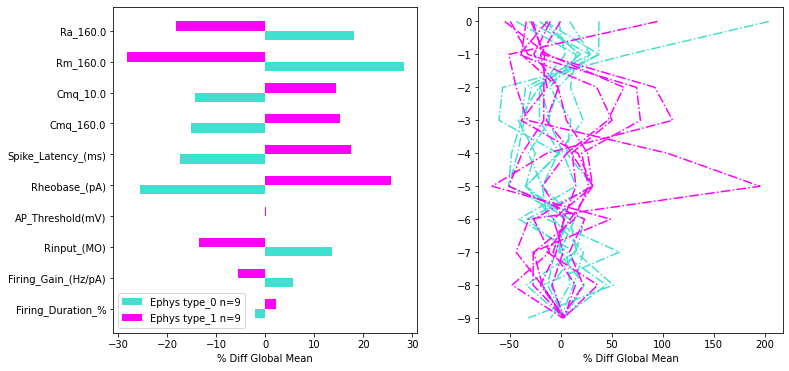

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
####### PCA CLUSTER ##########

# _ = [print(c,cell_summary_exl_friendly.columns[c]) for c in range(len(cell_summary_exl_friendly.columns))]
col_inds_for_pca = [9] + [12] + list(range(13,17)) + [18] + list(range(31,40))
cols_for_pca = cell_summary_exl_friendly.columns[col_inds_for_pca]

cols_for_pca = [ 'Ra_160.0', 'Rm_160.0','Cmq_10.0', 'Cmq_160.0','Spike_Latency_(ms)', 'Rheobase_(pA)',
                'AP_Threshold(mV)', 'Rinput_(MO)', 'Firing_Gain_(Hz/pA)',
                'Firing_Duration_%' ] #,'Gain_NumSpikes_0', 'Gain_NumSpikes_1',
                # 'Gain_NumSpikes_2', 'Gain_NumSpikes_3', 'Gain_NumSpikes_4',
                # 'Gain_NumSpikes_5', 'Gain_NumSpikes_6', 'Gain_NumSpikes_7',
                # 'Gain_NumSpikes_8', 'Gain_NumSpikes_9']



# _ = [print(c) for c in cols_for_pca]
df = cell_summary_exl_friendly[cols_for_pca]
# display(df)
X_ = df.to_numpy(dtype='float32')
nan_bool = np.logical_not(np.isnan(X_))
row_nan = np.all(nan_bool,axis=1)
df = df[row_nan]
# display(df)
X_ = X_[row_nan,:]
# print(X_)


import sklearn.decomposition
import sklearn.cluster

pca = sklearn.decomposition.PCA(n_components=np.min(X_.shape)).fit(X_)
print(np.cumsum(pca.explained_variance_ratio_))
pca = sklearn.decomposition.PCA(n_components=3).fit(X_)
print(np.cumsum(pca.explained_variance_ratio_))

X_trans = pca.transform(X_)
X_red = pca.inverse_transform(X_trans)


RANDOM_SEED = 5
kmeans = sklearn.cluster.KMeans(n_clusters=2,random_state=RANDOM_SEED).fit(X_trans)
Centroids_red = pca.inverse_transform(kmeans.cluster_centers_)
null_kmeans = sklearn.cluster.KMeans(n_clusters=1).fit(X_trans)
null_centoid =  pca.inverse_transform(null_kmeans.cluster_centers_)[0]
# print(Centroids_red)
# print(null_centoid)

type_0_cent = 100*(Centroids_red[0] / null_centoid - 1)
type_1_cent = 100*(Centroids_red[1] / null_centoid - 1)

X_rel = (100*(X_ / null_centoid - 1))


fig,axs = plt.subplots(1,2,figsize=(12, 6))
x = np.arange(len(cols_for_pca))*-1

wid = .3


is_type_0 = kmeans.labels_ == 0
is_type_1 = kmeans.labels_ == 1
X_at0 = X_rel[is_type_0,:]  
X_at1 = X_rel[is_type_1,:] 


axs[0].barh(x-wid/2, type_0_cent, wid,color = 'turquoise',label='Ephys type_0'+' n=' +str(sum(is_type_0)))
axs[0].barh(x+wid/2, type_1_cent, wid,color = 'magenta',label='Ephys type_1'+' n=' +str(sum(is_type_1)))

x_exp0 = np.repeat(np.expand_dims(x, axis=0),repeats =sum(is_type_0), axis=0)
axs[1].plot(X_at0.transpose(), x_exp0.transpose(), '-.',color = 'turquoise')

x_exp1 = np.repeat(np.expand_dims(x, axis=0),repeats =sum(is_type_1), axis=0)
axs[1].plot(X_at1.transpose(), x_exp1.transpose(), '-.',color = 'magenta' )

for ax in axs:
    axs[0].legend()
    ax.set_yticks(x)
    axs[0].set_yticklabels(cols_for_pca, rotation=0)
    ax.set_xlabel('% Diff Global Mean')
plt.show()

fig.savefig('clusters.png',dpi=300)
files.download('clusters.png')

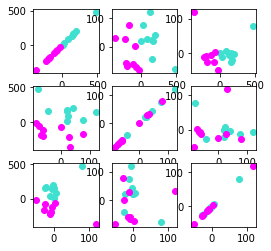

In [28]:
# print(X_trans)
# print(X_trans[is_type_0])

fig, ax = plt.subplots(3,3,figsize = [4,4])
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(X_trans[is_type_0][:,i],X_trans[is_type_0][:,j],color='turquoise')
        ax[i,j].scatter(X_trans[is_type_1][:,i],X_trans[is_type_1][:,j],color='magenta')
